In [1]:
import pandas as pd
import numpy as np
import psycopg2

In [2]:
try:
    conn = psycopg2.connect(dbname='mimic', user='tianranzhang')
except:
        print("I am unable to connect to the database")

cur = conn.cursor()
cur.execute("""set search_path to mimiciii""")
cur.execute("""select FLOOR(a.hadm_id), a.subject_id, a.charttime, 
'labevent' as event_type, b.loinc_code as event, a.flag as event_info 
from labevents a, d_labitems b
where a.itemid = b.itemid
and a.itemid in
(
  select itemid from
  (
    select hadm_id, itemid from labevents where flag='abnormal' group by hadm_id, itemid
  ) as uniqlab
  group by itemid having count(*) > 50
)
and a.subject_id in (select subject_id from admissions group by subject_id having count(*) > 1)
and a.hadm_id is not NULL
order by a.subject_id, a.charttime
""")
labs = cur.fetchall()
print("Query executed")

Query executed


In [3]:
labs = pd.DataFrame(labs)
labs.columns = ['hadm_id','subject_id', 'charttime', 'event_type','event','event_info']
labs.count()

hadm_id       7580984
subject_id    7580984
charttime     7580984
event_type    7580984
event         7571755
event_info    3370295
dtype: int64

In [13]:
labs.head()

,hadm_id,subject_id,charttime,event_type,event,event_info
0,194023.0,17,2134-12-27 15:55:00,labevent,34728-6,None
1,194023.0,17,2134-12-27 15:55:00,labevent,1994-3,None
2,194023.0,17,2134-12-27 15:55:00,labevent,2339-0,None
3,194023.0,17,2134-12-27 15:55:00,labevent,718-7,None
4,194023.0,17,2134-12-27 15:55:00,labevent,11557-6,None


In [9]:
list(labs.event_info)[1]

In [6]:
sum(labs.hadm_id.value_counts()>10)
#189 unique lab codes with mapped loinc_id

19315

In [14]:
labs.to_csv('labevents_info.csv',index=False)

In [7]:
len(labs.subject_id.unique())

7536

In [8]:
list(labs.query('subject_id == 17').hadm_id.unique())

[194023.0, 161087.0]

### generate mapping: subject_id--->last hadm_id

In [4]:
try:
    conn = psycopg2.connect(dbname='mimic', user='tianranzhang')
except:
        print("I am unable to connect to the database")

cur = conn.cursor()
cur.execute("""set search_path to mimiciii""")
cur.execute("""
select subject_id, hadm_id, admittime, dischtime
from 
admissions
where (subject_id, admittime) in 
(select subject_id, max(admittime)
from admissions
where  hadm_id  in
(select a.hadm_id
from labevents a, d_labitems b
where a.itemid = b.itemid
and a.itemid in
(
  select itemid from
  (
    select hadm_id, itemid from labevents where flag='abnormal' group by hadm_id, itemid
  ) as uniqlab
  group by itemid having count(*) > 50
)
and a.subject_id in (select subject_id from admissions group by subject_id having count(*) > 1)
and a.hadm_id is not NULL) 
group by subject_id)
order by subject_id
""")
curr = cur.fetchall()
print("Query executed")

Query executed


In [5]:
last_adm_info = pd.DataFrame(curr)
last_adm_info.columns = ['subject_id', 'hadm_id','admittime', 'dischtime']
last_adm_info.head()

,subject_id,hadm_id,admittime,dischtime
0,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00
1,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00
3,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00
4,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00


In [23]:
last_adm_info.to_csv('last_adm_info.csv', index = False)

In [6]:
labs_filtered = labs.query('event_info not in [None]')
labs_filtered = labs_filtered[labs_filtered['event_info'].str.match('abnormal')]

In [8]:
labs_filtered.to_csv('labevents_abnormal.csv',index=False)

In [15]:
np.max(labs_filtered.groupby(['subject_id','charttime']).event.count().max(level=0))

37

In [17]:
#Sanity check
train_seqs = pd.DataFrame(columns=['subject_id','seq'])
for i in list(labs_filtered.subject_id.unique()):
    curr_subj = labs_filtered.query('subject_id == '+str(i) +'and hadm_id!='+str(list(last_adm_info.query('subject_id == '+str(i)).hadm_id)[0])).event
    print(len(list(curr_subj)))
    if len(list(curr_subj)) == 0:
        print ('adm num:',len(labs_filtered.query('subject_id == '+str(i)).hadm_id.unique()))
    else:
        train_seqs = train_seqs.append({'subject_id': str(i), 'seq': ','.join(i for i in list(curr_subj) if i is not None)}, ignore_index=True)

57
326
75
27
487
507
0
adm num: 1
245
19
171
77
57
118
135
3503
191
47
99
277
132
48
308
1807
87
246
186
131
157
54
1026
187
247
55
76
149
148
321
363
221
380
438
480
319
310
883
55
69
234
5
11
585
421
132
379
74
43
783
187
54
890
135
2612
58
71
103
82
681
199
154
236
486
15
104
583
160
932
311
264
456
8
204
164
38
303
68
642
96
306
5
170
0
adm num: 1
56
9
66
233
533
331
53
31
117
2822
206
23
211
108
99
36
762
407
110
20
65
915
1054
38
21
95
101
196
957
103
0
adm num: 1
45
149
498
143
59
582
201
98
74
65
1556
17
137
0
adm num: 1
277
330
769
271
7
46
425
612
137
33
169
0
adm num: 1
159
872
123
317
34
114
72
114
1634
1218
69
680
69
104
697
42
106
238
186
630
38
47
378
282
2
43
273
367
1128
0
adm num: 1
292
93
39
918
50
136
252
324
185
9
88
414
58
285
583
72
66
75
224
497
220
1152
113
449
0
adm num: 1
12
103
131
13
33
0
adm num: 1
33
317
45
148
33
95
615
143
86
110
406
49
3
25
835
6
756
706
368
49
131
117
216
255
92
78
0
adm num: 1
112
45
296
29
575
42
80
18
212
157
69
43
178
90
163
152
1

1733
308
0
adm num: 1
2
164
118
49
0
adm num: 1
48
1495
138
325
1298
49
29
0
adm num: 1
0
adm num: 1
49
1023
406
59
5
182
35
23
5480
195
14
329
111
50
107
102
5
676
0
adm num: 1
212
37
302
37
619
50
167
36
208
52
48
38
139
412
102
111
87
487
580
203
63
103
155
87
100
138
223
205
1069
76
8
87
334
119
2
301
179
141
157
100
41
53
38
97
1071
244
450
48
92
2921
248
12
163
80
58
164
14
851
1259
123
694
56
243
79
68
1378
162
75
33
7
144
145
11
21
43
311
63
862
57
228
48
3
296
71
491
126
138
12
113
1264
331
507
10
3237
184
19
25
0
adm num: 1
0
adm num: 1
124
130
205
69
175
492
0
adm num: 1
133
69
228
319
27
152
0
adm num: 1
8
222
10
183
489
794
1086
17
428
303
70
153
23
589
2243
62
207
632
166
362
582
31
53
47
1185
246
177
335
124
721
247
100
356
470
1089
107
168
88
0
adm num: 1
75
104
92
717
70
361
130
143
455
36
109
121
178
397
266
105
68
85
0
adm num: 1
78
79
0
adm num: 1
336
249
0
adm num: 1
19
37
177
92
193
20
24
125
94
129
192
540
701
148
90
98
118
264
40
117
7
214
99
86
221
232
151
167


109
25
112
30
343
185
127
383
30
252
446
144
740
108
1
4
269
64
16
780
91
66
0
adm num: 1
604
194
61
1003
341
261
210
508
62
180
50
1548
133
49
49
65
841
0
adm num: 1
251
76
113
0
adm num: 1
17
301
11
660
445
364
0
adm num: 1
173
516
27
185
195
126
198
104
56
1073
71
0
adm num: 1
113
79
160
64
207
984
421
279
279
206
549
127
158
134
18
48
83
127
495
192
576
94
350
595
65
165
71
54
94
548
27
71
759
416
20
999
357
325
536
1412
241
176
714
91
17
865
400
233
1428
352
513
24
86
519
73
125
127
471
39
54
156
224
264
188
1679
1239
0
adm num: 1
131
460
29
4
409
1358
99
135
155
20
173
126
66
188
96
279
239
39
256
645
31
126
50
81
121
15
78
0
adm num: 1
1
40
0
adm num: 1
93
2
199
79
72
456
418
2346
122
2917
702
325
49
216
11
11
365
265
534
58
111
37
105
97
1332
131
965
61
137
64
328
183
1903
28
90
143
460
653
24
56
464
123
212
57
105
507
59
44
59
427
66
129
226
129
823
342
157
250
44
410
445
16
59
59
91
69
74
180
135
34
424
613
56
22
228
46
87
64
114
32
38
452
9
1403
165
152
1304
59
78
161
37
168

39
35
122
358
72
710
5
275
176
0
adm num: 1
99
84
93
44
111
73
74
260
84
64
97
63
277
147
156
115
48
229
60
355
60
138
120
102
26
600
89
391
27
23
7
0
adm num: 1
559
990
56
544
76
198
378
30
19
435
263
99
0
adm num: 1
311
185
68
119
412
36
83
88
63
82
269
98
250
490
29
200
82
279
531
57
527
32
1037
50
131
348
674
12
129
146
469
162
66
63
166
30
28
180
100
118
129
318
153
135
76
83
137
55
276
57
196
52
65
56
72
123
187
59
107
5
255
0
adm num: 1
137
24
323
132
223
328
33
71
365
19
230
62
137
255
479
221
93
90
274
62
1614
91
92
179
109
1916
47
105
33
0
adm num: 1
44
91
272
160
51
150
361
338
371
62
238
103
72
435
132
310
35
114
688
556
19
180
1336
412
1098
923
74
82
89
229
95
124
178
92
175
182
282
347
123
937
345
224
240
704
242
115
0
adm num: 1
138
128
623
110
2
9
63
293
0
adm num: 1
375
260
36
243
84
56
156
66
66
73
292
21
941
51
99
72
390
191
25
15
1069
111
95
57
1003
0
adm num: 1
108
195
40
338
36
74
153
1400
298
32
333
8
213
85
77
183
78
161
164
1501
77
78
418
319
92
104
25
152
103


In [25]:
len(labs.query('event_info not in [@pd.NaT]'+' and subject_id == '+'17' +'and hadm_id!='+str(list(last_adm_info.query('subject_id == '+'17').hadm_id)[0])).event)

145

In [35]:
len(labs.query('event_info not in [None]'+'and subject_id == '+'17' +'and hadm_id!='+str(list(last_adm_info.query('subject_id == '+'17').hadm_id)[0])).event_info)

59

In [12]:
train_seqs.head()

,subject_id,seq
0,17,"34728-6,1994-3,2339-0,718-7,11557-6,11558-4,11..."
1,21,"1863-0,1963-8,2000-8,2075-0,20569-0,2157-6,677..."
2,23,"34728-6,1994-3,2339-0,718-7,11557-6,11558-4,11..."
3,34,"34728-6,11557-6,11558-4,11556-8,1863-0,1963-8,..."
4,36,"4548-4,1742-6,1751-7,6768-6,1863-0,1920-8,1963..."


In [20]:
train_seqs.count()

subject_id    7243
seq           7243
dtype: int64

### Drugs

In [16]:
try:
    conn = psycopg2.connect(dbname='mimic', user='tianranzhang')
except:
        print("I am unable to connect to the database")

cur = conn.cursor()
cur.execute("""set search_path to mimiciii""")
cur.execute("""select hadm_id, subject_id, startdate as charttime, 'prescription' as event_type, 
formulary_drug_cd as event 
from prescriptions
where formulary_drug_cd in
(
  select formulary_drug_cd from
  (
    select hadm_id, formulary_drug_cd from prescriptions group by hadm_id, formulary_drug_cd
  ) as uniqlab
  group by formulary_drug_cd having count(*) > 50
)
and subject_id in (select subject_id from admissions group by subject_id having count(*) > 1)
""")
meds = cur.fetchall()
print("Query executed")

Query executed


In [17]:
meds = pd.DataFrame(meds)
meds.columns = ['hadm_id','subject_id', 'charttime', 'event_type','event']
meds.count()

hadm_id       1620375
subject_id    1620375
charttime     1618939
event_type    1620375
event         1620375
dtype: int64

In [18]:
meds.event.value_counts()

FURO40I        35652
INSULIN        35572
NACLFLUSH      31329
NS1000         23921
D5W250         23611
NS500          23584
VANC1F         23410
VANCOBASE      23390
HEPA5I         22457
MAG2PM         20909
NS250          20810
METO25         19288
METO5I         18746
ACET325        18665
KCL20PM        18613
KCLBASE2       18577
MICROK10       17135
NS100          15571
DOCU100        14844
HEPBASE        14773
KCL20P         14696
GLAR100I       14270
MAGS1I         14117
LR1000         13604
LORA2I         13167
ALBU3H         11851
PANT40         11767
CALG1I         11551
SENN187        11461
MORP2I         11081
               ...  
NEUT1I            18
PRED125ES         17
NEOMET30L         17
LOVA20            17
STARTNEOD5        17
MULTNEO           17
MAXI1ES           16
OLME20            15
NEOSYR1ML         15
GENT20I           14
NEOTRIVIT         13
MORP1-8           13
CLIN900PM         12
DTAP              11
NMORP             10
CYCL1O            10
POLIOV       

## label extraction

In [21]:
try:
    conn = psycopg2.connect(dbname='mimic', user='tianranzhang')
except:
        print("I am unable to connect to the database")

cur = conn.cursor()
cur.execute("""set search_path to mimiciii""")
cur.execute("""select HADM_ID, subject_id, seq_num, icd9_code
from diagnoses_icd
where subject_id in (select subject_id from admissions group by subject_id having count(*) > 1)
order by hadm_id, subject_id, seq_num
""")
icd = cur.fetchall()
print("Query executed")

Query executed


In [22]:
icd = pd.DataFrame(icd)
icd.columns = ['hadm_id','subject_id', 'seq_num', 'icd9_code']
icd.count()

hadm_id       260326
subject_id    260326
seq_num       260282
icd9_code     260282
dtype: int64

In [15]:
len(icd.hadm_id.unique())

19993

### Extracting label sequence and generate the master dataset

In [16]:
list(train_seqs[train_seqs.subject_id.isin(['17'])].seq)[0]

'34728-6,1994-3,2339-0,718-7,11557-6,11558-4,11556-8,6298-4,2947-0,34728-6,2339-0,718-7,11557-6,11558-4,11556-8,6298-4,34728-6,2339-0,718-7,11557-6,11558-4,11556-8,6298-4,3255-7,4544-3,718-7,5895-7,785-6,786-4,787-2,777-3,5902-2,3173-2,788-0,789-8,804-5,34728-6,1994-3,2339-0,718-7,11557-6,11558-4,11556-8,6298-4,2947-0,1963-8,2075-0,2160-0,3094-0,34728-6,1994-3,2339-0,11557-6,11558-4,11556-8,6298-4,2947-0,34728-6,11557-6,11558-4,11556-8,34728-6,11557-6,11558-4,11556-8,34728-6,2339-0,11557-6,11558-4,11556-8,1863-0,1963-8,2075-0,2160-0,2345-7,2823-3,2951-2,3094-0,4544-3,718-7,785-6,786-4,787-2,777-3,788-0,789-8,804-5,2601-3,2823-3,4544-3,1994-3,11558-4,1994-3,2339-0,11557-6,11558-4,11556-8,6298-4,34728-6,2951-2,785-6,1863-0,1963-8,2000-8,2075-0,2160-0,2345-7,786-4,2601-3,787-2,2777-1,3094-0,777-3,2823-3,4544-3,788-0,789-8,718-7,804-5,1994-3,32693-4,11557-6,11558-4,11556-8,34728-6,4544-3,718-7,785-6,786-4,787-2,777-3,788-0,789-8,804-5,1863-0,1963-8,2000-8,2075-0,2160-0,2345-7,2601-3,2777-1

In [43]:
list(train_seqs[train_seqs.subject_id.isin(['17'])].seq)[0]

'11556-8,34728-6,2339-0,718-7,11557-6,11558-4,11556-8,2339-0,718-7,11556-8,4544-3,718-7,786-4,777-3,5902-2,789-8,2339-0,718-7,11557-6,11558-4,2075-0,11558-4,11556-8,11557-6,11558-4,11556-8,11558-4,11556-8,2339-0,11558-4,11556-8,2075-0,2345-7,4544-3,718-7,786-4,789-8,804-5,2601-3,4544-3,1994-3,2339-0,11556-8,2000-8,2345-7,786-4,2777-1,4544-3,789-8,718-7,804-5,11556-8,4544-3,718-7,789-8,2000-8,2345-7'

In [9]:
all_train= pd.DataFrame(columns=['subject_id','seq','HF'])
label_seqs = pd.DataFrame(columns=['subject_id','seq'])
for i in list(train_seqs.subject_id.unique()):
    curr_subj = icd.query('subject_id == '+str(i)+'and hadm_id =='+str(list(last_adm_info.query('subject_id == '+str(i)).hadm_id)[0])).icd9_code
    print(len(list(curr_subj)))
    label_seqs = label_seqs.append({'subject_id': str(i), 'seq': [i for i in list(curr_subj) if i is not None]}, ignore_index=True)
    all_train = all_train.append({'subject_id': str(i), 'seq': ' '.join(list(train_seqs[train_seqs.subject_id.isin([str(i)])].seq)[0].split(',')), 'HF':1*('4280' in [i for i in list(curr_subj) if i is not None]) }, ignore_index=True)

NameError: name 'pd' is not defined

In [45]:
print(list(all_train.seq)[0])

11556-8 34728-6 2339-0 718-7 11557-6 11558-4 11556-8 2339-0 718-7 11556-8 4544-3 718-7 786-4 777-3 5902-2 789-8 2339-0 718-7 11557-6 11558-4 2075-0 11558-4 11556-8 11557-6 11558-4 11556-8 11558-4 11556-8 2339-0 11558-4 11556-8 2075-0 2345-7 4544-3 718-7 786-4 789-8 804-5 2601-3 4544-3 1994-3 2339-0 11556-8 2000-8 2345-7 786-4 2777-1 4544-3 789-8 718-7 804-5 11556-8 4544-3 718-7 789-8 2000-8 2345-7


In [46]:
all_train.HF.count()

7235

### Generating all sequences for embedding training

In [48]:
#vocab size: 
#  - all labs: 187
#  - abnormal labs: 187
len(set(' '.join(list(all_train.seq)).split(' ')))

187

In [47]:
#average sequence length
# - all labs: 662
# - abnormal labs: 287.73
import statistics
statistics.mean(len(i.split(' ')) for i in list(all_train.seq))

287.73061506565307

/home/tianranzhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


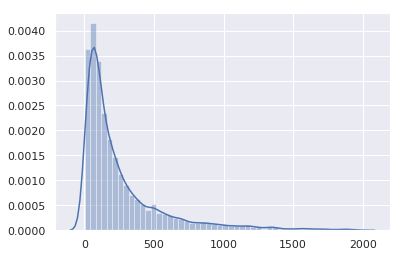

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
sns.distplot([len(i.split(' ')) for i in list(all_train.seq) if len(i.split(' '))<2000])

In [51]:
#write the all sequences file
with open("all_sequences_abnorm.txt", "w") as text_file:
    text_file.write('\n'.join(list(all_train.seq)))

In [2]:
all_sequences[0]

'34728-6 1994-3 2339-0 718-7 11557-6 11558-4 11556-8 6298-4 2947-0 34728-6 2339-0 718-7 11557-6 11558-4 11556-8 6298-4 34728-6 2339-0 718-7 11557-6 11558-4 11556-8 6298-4 3255-7 4544-3 718-7 5895-7 785-6 786-4 787-2 777-3 5902-2 3173-2 788-0 789-8 804-5 34728-6 1994-3 2339-0 718-7 11557-6 11558-4 11556-8 6298-4 2947-0 1963-8 2075-0 2160-0 3094-0 34728-6 1994-3 2339-0 11557-6 11558-4 11556-8 6298-4 2947-0 34728-6 11557-6 11558-4 11556-8 34728-6 11557-6 11558-4 11556-8 34728-6 2339-0 11557-6 11558-4 11556-8 1863-0 1963-8 2075-0 2160-0 2345-7 2823-3 2951-2 3094-0 4544-3 718-7 785-6 786-4 787-2 777-3 788-0 789-8 804-5 2601-3 2823-3 4544-3 1994-3 11558-4 1994-3 2339-0 11557-6 11558-4 11556-8 6298-4 34728-6 2951-2 785-6 1863-0 1963-8 2000-8 2075-0 2160-0 2345-7 786-4 2601-3 787-2 2777-1 3094-0 777-3 2823-3 4544-3 788-0 789-8 718-7 804-5 1994-3 32693-4 11557-6 11558-4 11556-8 34728-6 4544-3 718-7 785-6 786-4 787-2 777-3 788-0 789-8 804-5 1863-0 1963-8 2000-8 2075-0 2160-0 2345-7 2601-3 2777-1

In [2]:
with open("all_sequences_abnorm.txt", "r") as text_file:
    all_sequences = [i.replace('\n','') for i in text_file]

### Train embedding model

In [3]:
import gensim

len_seq = 200
skip_gram = 1
win_size = 20
dim = 50

sequences = [i.split(' ') for i in all_sequences]#[i.split(' ') for i in list(all_train.seq)]
_model = gensim.models.Word2Vec(sequences, sg=skip_gram, window = win_size, iter=5, size= dim, min_count=1, workers=20)

#all_sequences_u = mapped

In [50]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
def w2v_mapping(sequences, _model,len_seq):
    mapped = []
    for i in sequences:
        mapped.append([_model[j].tolist() for index, j in enumerate(i) if index>len(i)-len_seq])
    mapped = np.array(pad_sequences(mapped, maxlen= len_seq, dtype='float', padding='pre', truncating='pre', value=0.0))
    return mapped

Using TensorFlow backend.


In [ ]:
[e for  w2v_model.wv[e] in feed_events if e in self._model.wv.vocab]

### train-val-test split

In [5]:
#split subj list 75%, 12.5%, 12.5%
import random
subj_list = all_train.subject_id
random.shuffle(subj_list)
tot = len(subj_list)
train_list = subj_list[:int(tot*0.75)]
val_list = subj_list[int(tot*0.75):int(tot*0.875)]
test_list = subj_list[int(tot*0.875):]

train_list.to_csv('train_list.csv',index=False)
val_list.to_csv('val_list.csv',index=False)
test_list.to_csv('test_list.csv',index=False)
#split the master set
train_data = all_train[all_train.subject_id.isin(train_list)]
val_data = all_train[all_train.subject_id.isin(val_list)]
test_data = all_train[all_train.subject_id.isin(test_list)]


train_data.to_csv('train_lab_abnorm.csv',index=False)
val_data.to_csv('val_lab_abnorm.csv',index=False)
test_data.to_csv('test_lab_abnorm.csv',index=False)

NameError: name 'all_train' is not defined

In [8]:
train_data = pd.read_csv("train_lab_abnorm.csv")
val_data = pd.read_csv("val_lab_abnorm.csv")
test_data = pd.read_csv("test_lab_abnorm.csv")

In [9]:
train_x = w2v_mapping([i.split(' ') for i in train_data.seq], _model,len_seq)
val_x = w2v_mapping([i.split(' ') for i in val_data.seq], _model,len_seq)
test_x = w2v_mapping([i.split(' ') for i in test_data.seq], _model,len_seq)

#normalisation
#std = np.std(np.asarray(train_x))
#mean = np.mean(np.asarray(train_x))
#train_x = (np.asarray(train_x) - mean)/std
#val_x = (np.asarray(val_x) - mean)/std
#test_x =(np.asarray(test_x) - mean)/std



/home/tianranzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
len(train_data)

5426

In [10]:
train_y = train_data.HF
val_y = val_data.HF
test_y = test_data.HF

### train predictive model for HF

In [11]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]   
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
def precision(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.precision(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'precision' in i.name.split('/')[1]]  
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
      
def recall(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.recall(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'recall' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value


In [12]:
#RNN model
import numpy
from keras import optimizers
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.layers import LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras_metrics
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.callbacks import TensorBoard


def training(train_data, val_data, test_data, onehot_train, onehot_val, onehot_test, curr_cross_val = 0, 
             dim = 256, len_seq = 50, cnn_dim = 200, epoch_num = 20):
  # fix random seed for reproducibility
    numpy.random.seed(100)
  #model = Sequential()
  #if (lstm_num == 1):
    #model.add(LSTM(lstm_dim, input_shape=(200,dim)))
  #else:
    #model.add(LSTM(lstm_dim, input_shape=(200,dim), return_sequences=True))
    #model.add(LSTM(int(lstm_dim/2)))
  #model.add(Dense(target_num, activation='sigmoid'))
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc_roc, precision, recall])#keras_metrics.precision(),keras_metrics.recall()])
  #print(model.summary())
  accommadation
    import keras
    from keras.layers import Dense,Conv1D,MaxPooling1D,Dropout
    from keras.models import Input, Model
  #from tcn import TCN
    batch_size, timesteps, input_dim = None, len_seq, dim
    from keras.layers import LeakyReLU
  
  
    ksize=3
    i = Input(batch_shape=(batch_size, timesteps, input_dim))
    o = Conv1D(cnn_dim, kernel_size=ksize, strides=ksize, padding='valid', dilation_rate=1,  activation=None, use_bias=True)(i)
    o = LeakyReLU(alpha=0.3)(o)
    o = Conv1D(cnn_dim, kernel_size=ksize, strides=ksize, padding='valid',dilation_rate=1,  activation=None, use_bias=True)(i)
    o = LeakyReLU(alpha=0.3)(o)
    o = Conv1D(cnn_dim, kernel_size=ksize, strides=ksize, padding='valid', dilation_rate=1, activation=None, use_bias=True)(i)
    o = LeakyReLU(alpha=0.3)(o)
    o = GRU(cnn_dim,dropout = 0.2)(o)
    o = Dense(1,activation='sigmoid')(o)

    m = Model(inputs=[i], outputs=[o])
    m.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy',auc_roc, precision, recall])
  
  #import datetime
  #curr_run_time= datetime.datetime.now()
    #if not os.path.exists("model_checkpoints/tcn/"+target+"/"+str(run_num)+ "/cv"+ str(curr_cross_val)+"/"):
        #os.mkdir("model_checkpoints/tcn/"+target+"/"+str(run_num)+ "/cv"+ str(curr_cross_val)+"/")
    #filepath = "model_checkpoints/tcn/"+target+"/"+str(run_num)+ "/cv"+ str(curr_cross_val)+"/saved-model-{epoch:02d}-{val_loss:.4f}.hdf5"
    #checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    
    tsbd = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    callbacks_list = [tsbd]
  
    m.fit(train_data, onehot_train, validation_data=(val_data, onehot_val), epochs=epoch_num, batch_size=128,callbacks=callbacks_list)

    #h = model.fit(train_data, onehot_train,validation_data=(val_data, onehot_val), epochs=epoch_num, batch_size=64,callbacks=callbacks_list)
  
    predicted_val = m.predict(val_data)
    predicted_test = m.predict(test_data)
    scores_val = m.evaluate(val_data, onehot_val, verbose=0)
    scores_test = m.evaluate(test_data, onehot_test, verbose=0)
    # Final evaluation of the model
    scores_val = m.evaluate(val_data, onehot_val, verbose=0)
    scores_test = m.evaluate(test_data, onehot_test, verbose=0)
    return [predicted_val, predicted_test,scores_val,scores_test]

In [13]:
len(train_x[0][0])

50

In [14]:
import csv
import os
import uuid
curr_dim = 50
len_seq = 200
cnn_dim = 200
epoch_num = 10
acc_val = []
acc_test = []
auc_vals = []
auc_test = []
prauc_vals = []
prauc_test = []
prec_val = []
prec_test = []
rec_val = []
rec_test = []
for curr_cross_val in np.arange(1):
    #train
    #making directories to save models/predictions for val/test
    import tensorflow as tf       
    predicted_val, predicted_test,scores_val,scores_test = training(train_x, val_x, test_x, train_y, val_y, test_y, 
                                                curr_cross_val, curr_dim,len_seq, cnn_dim, epoch_num)
    from sklearn.metrics import roc_auc_score, average_precision_score,precision_score, recall_score,roc_curve,auc
    #TODO: pick the threshold that gives the best F1
    acc_val.append(scores_val[1])
    acc_test.append(scores_test[1])
    fpr, tpr, _ = roc_curve(val_y,predicted_val)
    auc_vals.append(auc(fpr, tpr))
    fpr, tpr, _ = roc_curve(test_y,predicted_test)
    auc_test.append(auc(fpr, tpr))
    prec_val.append(precision_score(val_y,(predicted_val>0.5)*1))
    prec_test.append(precision_score(test_y,(predicted_test>0.5)*1))
    rec_val.append(recall_score(val_y,(predicted_val>0.5)*1))
    rec_test.append(recall_score(test_y,(predicted_test>0.5)*1))
    prauc_vals.append(average_precision_score(val_y,predicted_val))
    prauc_test.append(average_precision_score(test_y,predicted_test))
    if not os.path.exists("tcn_abnormlabs_baseline/"):
        tf.gfile.MkDir("tcn_abnormlabs_baseline/")
    if not os.path.exists("tcn_abnormlabs_baseline/"+ "/cv"):
        tf.gfile.MkDir("tcn_abnormlabs_baseline/"+ "/cv")
    if not os.path.exists("tcn_abnormlabs_baseline/"+ "/cv"+ str(curr_cross_val)+"/"):
        tf.gfile.MkDir("tcn_abnormlabs_baseline/"+ "/cv"+ str(curr_cross_val)+"/")
    np.savetxt("tcn_abnormlabs_baseline/"+ "/cv"+ str(curr_cross_val)+"/"+"validation_pred"+str(uuid.uuid4())+".csv", predicted_val, delimiter=",")
    np.savetxt("tcn_abnormlabs_baseline/"+ "/cv"+ str(curr_cross_val)+"/"+"test_pred"+str(uuid.uuid4())+".csv", predicted_test, delimiter=",")
with open("tcn_abnormlabs_baseline/"+"exp_logs.csv", 'a', newline='') as csvFile:   
    writer = csv.DictWriter(csvFile, fieldnames=['acc_val','auc_vals','prec_val','rec_val', 'acc_test','auc_test','prec_test','rec_test',"prauc_vals","prauc_test","dim","cnn_dim","len_seq"])
    writer.writerow({'acc_val': str(np.mean(acc_val)),'auc_vals': str(np.mean(auc_vals)),'prec_val': str(np.mean(prec_val)),'rec_val': str(np.mean(rec_val)),
                    'acc_test': str(np.mean(acc_test)),'auc_test': str(np.mean(auc_test)),'prec_test': str(np.mean(prec_test)),'rec_test': str(np.mean(rec_test)), 
                    "prauc_vals":str(np.mean(prauc_vals)),"prauc_test":str(np.mean(prauc_test)),
                    'dim':str(dim),"cnn_dim":str(cnn_dim),"len_seq":str(len_seq)})
csvFile.close()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 5426 samples, validate on 904 samples
Epoch 1/10
5426/5426 [==============================] - 8s 2ms/step - loss: 0.6428 - acc: 0.6441 - auc_roc: 0.5319 - precision: 0.9764 - recall: 0.3467 - val_loss: 0.6215 - val_acc: 0.6737 - val_auc_roc: 0.5947 - va

### ICD code analysis

In [129]:
all_codes = []
for i in label_seqs.seq:
    all_codes = all_codes + i
all_codes

['4239',
 '5119',
 '78551',
 '4589',
 '311',
 '7220',
 '71946',
 '2724',
 '0388',
 '78552',
 '40391',
 '42731',
 '70709',
 '5119',
 '6823',
 '99859',
 '00845',
 '5720',
 '99592',
 'V0980',
 '25000',
 '2859',
 '43889',
 '2749',
 '41401',
 '185',
 '4439',
 '2449',
 'E8788',
 '2252',
 '3485',
 '78039',
 '4241',
 '4019',
 '2720',
 '2724',
 'V4581',
 'V4579',
 'V1582',
 '42789',
 '42822',
 '4263',
 '41401',
 'V5861',
 '4280',
 '2449',
 '3659',
 '55321',
 '41511',
 '5185',
 '486',
 '99739',
 '5180',
 '41400',
 '496',
 '4019',
 '60000',
 '30000',
 'V1051',
 '20280',
 '2848',
 '99685',
 '56983',
 '5672',
 '2762',
 '0389',
 '99591',
 '2763',
 '7994',
 '1120',
 '2765',
 '4589',
 '42731',
 '2554',
 '3510',
 '0880',
 '042',
 '486',
 '4254',
 '2762',
 '5849',
 '570',
 '5859',
 '2848',
 '2875',
 '4280',
 '2859',
 '1919',
 '3484',
 '78701',
 '56400',
 '0389',
 '486',
 'V4281',
 '23875',
 '42731',
 '41400',
 '3004',
 '2724',
 '2449',
 '60001',
 '78843',
 '32723',
 '3320',
 '3051',
 'V1079',
 'V4581',


In [221]:
import collections
code_frequencies = pd.DataFrame.from_dict(collections.Counter(all_codes), orient='index').reset_index().sort_values(0,ascending=False)
code_frequencies.columns = ['icd', ' count']
code_frequencies.head()

,icd,count
32,4019,2608
41,4280,2495
11,42731,2118
71,5849,1733
7,2724,1431


In [157]:
code_frequencies.query('icd =='+'4019')

,icd,count


In [156]:
list(code_frequencies.icd)[0]

'4019'

In [159]:
code_frequencies.to_csv('code_frequencies.csv',index=False)

### Permutation 

#### 1. Statistics for unordered sets

In [1]:
import pandas as pd
import numpy as npperm = "permutation_1_10"

labs_filtered = pd.read_csv('labevents_abnormal.csv')
last_adm_info = pd.read_csv('last_adm_info.csv')

In [2]:
#abnormal labs: 
#- max length of unordered lab events is 37
#- average max unordered lab events per patient: 16

np.mean(labs_filtered.groupby(['subject_id','charttime']).event.count().max(level=0))

16.264534112025483

#### 2. Generating permutated sequences

In [4]:
labs_filtered[labs_filtered['subject_id']==36].head("tcn_abnormlabs_baseline/"+"permutation_1_20.csv"with open("all_sequences_abnorm.txt", "w") as text_file:
    text_file.write('\n'.join(list(all_train.seq))))

SyntaxError: invalid syntax (<ipython-input-4-5caf07453222>, line 1)

In [24]:
a = [1,2,3,4,5]
perm_list = []
for cnt in ntp.arange(10):
    perm_list =perm_list+[list(np.random.permutation(a))]
perm_list

[[2, 4, 5, 1, 3],
 [2, 1, 3, 5, 4],
 [3, 2, 4, 1, 5],
 [5, 2, 3, 4, 1],
 [3, 1, 5, 2, 4],
 [4, 2, 1, 5, 3],
 [3, 4, 5, 2, 1],
 [4, 3, 2, 5, 1],
 [4, 1, 5, 2, 3],
 [4, 5, 3, 2, 1]]

In [3]:
def permutation(lst):
  
    # If lst is empty then there are no permutations 
    if len(lst) == 0: 
        return [] 
  
    # If there is only one element in lst then, only 
    # one permuatation is possible 
    if len(lst) == 1: 
        return [lst] 
  
    # Find the permutations for lst if there are 
    # more than 1 characters 
  
    l = [] # empty list that will store current permutation 
  
    # Iterate the input(lst) and calculate the permutation 
    for i in range(len(lst)):
        
        m = lst[i] 
  
       # Extract lst[i] or m from the list.  remLst is 
       # remaining list 
        remLst = lst[:i] + lst[i+1:] 
  
       # Generating all permutations where m is first 
       # element 
        for p in permutation(remLst): 
            l.append([m] + p) 
    return l

In [ ]:
#Todo: update this section to be consistent with the script
#Sanity check
import random
import csv
np.random.seed(100)
#train_seqs = pd.DataFrame(columns=['subject_id','seq'])
for i in list(labs_filtered.subject_id.unique()):
    print(i)
    if len(list(labs_filtered.query('subject_id == '+str(i)).hadm_id.unique())) ==1:
        continue;
    curr_subj = labs_filtered.query('subject_id == '+str(i) +'and hadm_id!='+str(list(last_adm_info.query('subject_id == '+str(i)).hadm_id)[0]))
    curr_subj_permutations = [list()]
    time_to_permutate = random.choice(list(curr_subj.charttime))
    print(time_to_permutate)
    charttime_list = []
    for t in list(curr_subj.charttime):
        if t in charttime_list:
            continue;
        charttime_list = charttime_list + [t]
    #charttime_list
    for k in charttime_list:#set(curr_subj.charttime):
    #print(k)
        unordered_set = list(curr_subj[curr_subj['charttime'] ==str(k)].event)
        if k == time_to_permutate:
            perm_list = permutation(unordered_set)
            if len(perm_list)>10:
                perm_list = random.choices(perm_list,k=10)
            for j in curr_subj_permutations:
                curr_subj_permutations = [j+l for l in perm_list]
        else:
            curr_subj_permutations = [i + unordered_set for i in curr_subj_permutations]
                
    with open("tcn_abnormlabs_baseline/"+"permutation_1_20.csv", 'a', newline='') as csvFile:   
        writer = csv.DictWriter(csvFile, fieldnames=['subject_id','seq'])

        for k in curr_subj_permutations:
                #train_seqs = train_seqs.append({'subject_id': str(i), 'seq': ','.join(i for i in k if i is not None)}, ignore_index=True)
            writer.writerow({'subject_id': str(i), 'seq': ','.join(i for i in k if i is not None)})
    csvFile.close()

17
2134-12-28 00:47:00
21
2134-09-13 09:00:00
23
2153-09-03 15:54:00
34
2186-07-19 02:56:00
36
2131-05-17 06:09:00


#### 3. Training model for permutated sequences

##### 3.1 loading data

##### 3.2 converting data into w2v vectors

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
def w2v_mapping(sequences, _model,len_seq):
    mapped = []
    for i in sequences:
        mapped.append([_model.wv[j].tolist() for index, j in enumerate(i) if index>len(i)-len_seq])
    mapped = np.array(pad_sequences(mapped, maxlen= len_seq, dtype='float', padding='pre', truncating='pre', value=0.0))
    return mapped

In [5]:
train_list = pd.read_csv('train_list_with_labels.csv', sep = '\t')
val_list = pd.read_csv('val_list_with_labels.csv', sep = '\t')
test_list = pd.read_csv('test_list_with_labels.csv', sep = '\t')

perm_sequences = pd.read_csv("tcn_abnormlabs_baseline/"+"permutation_1_10.csv")
perm_sequences.head()

,subject_id,seq
0,17,11556-8 34728-6 2339-0 718-7 11557-6 11558-4 1...
1,17,11556-8 34728-6 2339-0 718-7 11557-6 11558-4 1...
2,17,11556-8 34728-6 2339-0 718-7 11557-6 11558-4 1...
3,17,11556-8 34728-6 2339-0 718-7 11557-6 11558-4 1...
4,17,11556-8 34728-6 2339-0 718-7 11557-6 11558-4 1...


In [4]:
import gensim

len_seq = 200
skip_gram = 1
win_size = 20
dim = 50

sequences = [i.split(' ') for i in list(perm_sequences.seq)]#[i.split(' ') for i in list(all_train.seq)]
_model = gensim.models.Word2Vec(sequences, sg=skip_gram, window = win_size, iter=5, size= dim, min_count=1, workers=20)
del sequences

In [37]:
#spliting train/val/test sets
train_data = perm_sequences[perm_sequences.subject_id.isin(train_list.subject_id)]
val_data = perm_sequences[perm_sequences.subject_id.isin(val_list.subject_id)]
test_data = perm_sequences[perm_sequences.subject_id.isin(test_list.subject_id)]


In [5]:
#spliting train/val/test sets
train_data = perm_sequences[perm_sequences.subject_id.isin(train_list.subject_id)]
val_data = perm_sequences[perm_sequences.subject_id.isin(val_list.subject_id)]
test_data = perm_sequences[perm_sequences.subject_id.isin(test_list.subject_id)]

#spliting train/val/test labels
train_y = [int(train_list[train_list['subject_id']==i].HF) for i in train_list.subject_id if i in list(perm_sequences.subject_id) ]
val_y = [int(val_list[val_list['subject_id']==i].HF) for i in val_list.subject_id if i in list(perm_sequences.subject_id)]
test_y = [int(test_list[test_list['subject_id']==i].HF) for i in test_list.subject_id if i in list(perm_sequences.subject_id)]

In [6]:
del perm_sequences

In [ ]:
train_x = w2v_mapping([i.split(' ') for i in train_data.seq], _model,len_seq)
del train_data
val_x = w2v_mapping([i.split(' ') for i in val_data.seq], _model,len_seq)
del val_data 
test_x = w2v_mapping([i.split(' ') for i in test_data.seq], _model,len_seq)
del test_data

In [38]:
#spliting train/val/test labels
train_y = [int(train_list[train_list['subject_id']==i].HF) for i in train_data.subject_id]
val_y = [int(val_list[val_list['subject_id']==i].HF) for i in val_data.subject_id]
test_y = [int(test_list[test_list['subject_id']==i].HF) for i in test_data.subject_id]

In [39]:
len(train_y)

54200

In [32]:
len([val for val in train_y for _ in range(0, 10)])

54200

In [30]:
len(train_list)

5426

In [40]:
train_y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [34]:
import uuid

In [36]:
np.savetxt("set_learning/tcn_abnormlabs_baseline/"+"validation_pred"+str(uuid.uuid4())+".csv", [train_y,train_y], delimiter=",")


FileNotFoundError: [Errno 2] No such file or directory: 'set_learning/tcn_abnormlabs_baseline/validation_predff2c9080-dc0c-4149-9de2-cd4ee107f32a.csv'

In [22]:
train_list[train_list['subject_id']==29453].HF

0    0
Name: HF, dtype: int64

In [19]:
train_list['subject_id']

0       29453
1       81342
2         573
3       16911
4       99384
5       29261
6       96810
7       15935
8        3347
9        6283
10      24977
11      19815
12      65309
13      31198
14      22732
15      10222
16      70191
17      43126
18      30917
19      25574
20      16709
21      41795
22      59841
23      14316
24      14269
25      24099
26      31160
27      28099
28      29252
29      15843
        ...  
5396    61913
5397    20843
5398    58108
5399     6116
5400    15508
5401    28729
5402    79576
5403    24465
5404    23949
5405    30221
5406    30825
5407    62813
5408    78007
5409    26320
5410    77129
5411     5727
5412    23318
5413     7632
5414      703
5415    32742
5416    50391
5417    27472
5418    12993
5419    16055
5420    10434
5421    41902
5422    26136
5423     2100
5424    15687
5425     4954
Name: subject_id, Length: 5426, dtype: int64

In [42]:
test_data_ori = pd.read_csv('test_lab_abnorm.csv', sep = ',')

In [46]:
list(test_data_ori.HF)

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
